In [6]:
!pip install -q rfdetr supervision requests Pillow matplotlib
# For logging (optional)
!pip install -q "rfdetr[metrics]"

In [7]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: CUDA is not available. Training will be slow on CPU.")


CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [8]:
import os
import torch
from PIL import Image
import requests
import supervision as sv
from rfdetr import RFDETRBase
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
import json

In [9]:
# Initialize the base model, passing the device directly to the constructor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# The 'device' argument should be passed directly to the RFDETRBase constructor
# if it supports it, or it might handle device placement internally.
# Let's try passing it explicitly first, as this is the most common pattern.
try:
    model = RFDETRBase(device="cuda") # This is the most likely correct way
except TypeError:
    print("Warning: RFDETRBase constructor does not accept 'device' argument. Trying default initialization.")
    # If the above fails, it means the library might handle device internally
    # or expects it to be run on a specific environment.
    model = RFDETRBase() # Initialize without explicit device, and it should handle it.
    # In this case, ensure your environment (like Colab) is set up for GPU.


print("RF-DETR model loaded successfully.")

# You can still verify the model's device after initialization
# This might not work if the model encapsulates the actual nn.Module deeply.
# try:
#     print(f"Model is on device: {next(model.parameters()).device}")
# except Exception as e:
#     print(f"Could not verify model device directly: {e}")

Using device: cuda
Loading pretrain weights
RF-DETR model loaded successfully.


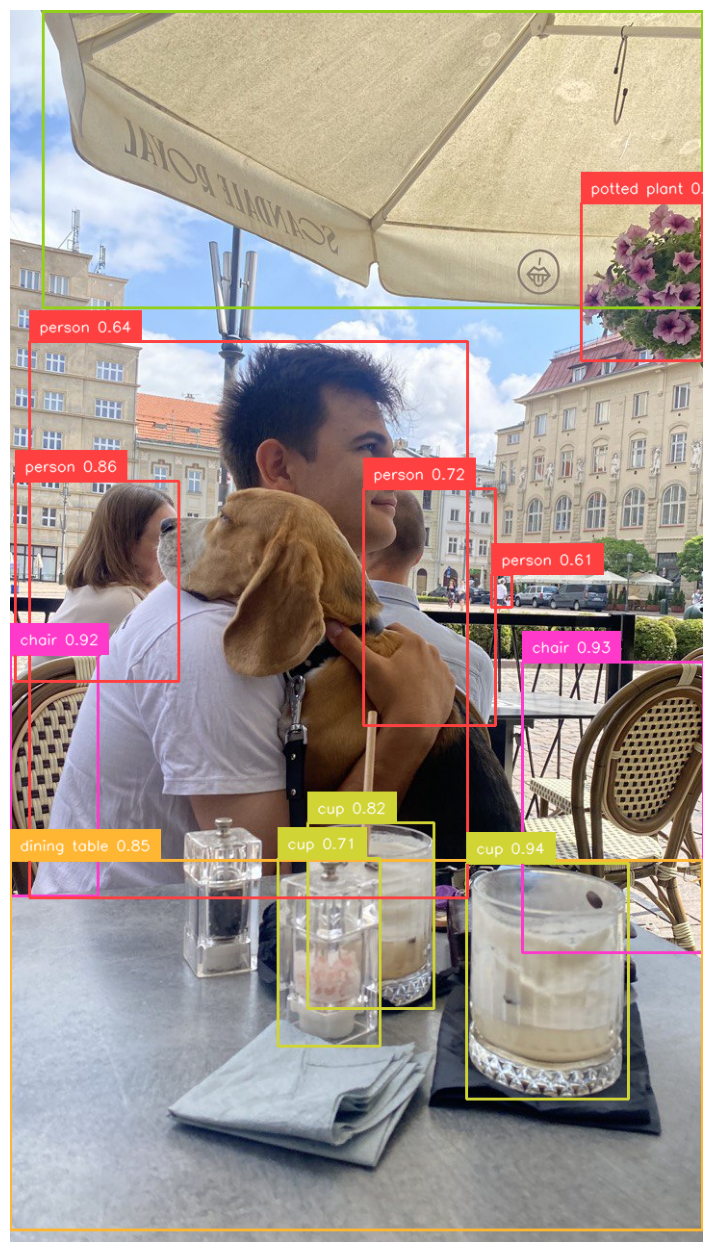

In [10]:
# Download a sample image
image_url = "https://media.roboflow.com/notebooks/examples/dog-2.jpeg"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

# Perform inference
# The `predict` method handles preprocessing internally
detections = model.predict(image, threshold=0.5) # Adjust threshold as needed

# Visualize detections
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# RF-DETR's predict method returns class_id which is typically 0-indexed.
# You'll need the COCO class names to map these IDs to human-readable labels.
# For simplicity, if you're using the base COCO model, you can get COCO classes:
COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(annotated_image, (16, 16))
plt.show()

Image loaded from: img2_rfdtr_test.jpg
Performing inference...
Found 3 objects.


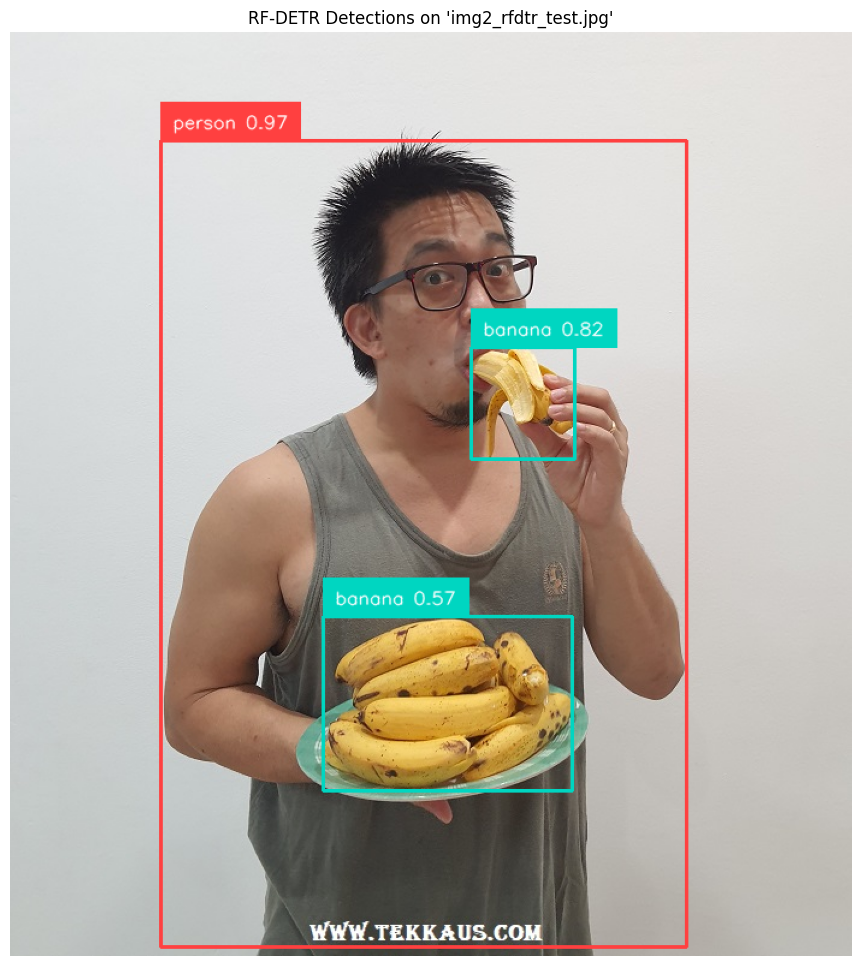

In [11]:
# 5.1. Specify the path to your image
# Make sure to replace 'path/to/your/image.jpg' with the actual path to your image file.
# Example if your image is in the same directory as the notebook:
# my_image_path = "my_custom_image.jpg"
# Or if it's in a subdirectory:
# my_image_path = "images/test_image.png"
my_image_path = "img2_rfdtr_test.jpg" # <--- IMPORTANT: Change this to your image path!

# 5.2. Load the image using PIL (Pillow)
try:
    image = Image.open(my_image_path).convert("RGB")
    print(f"Image loaded from: {my_image_path}")
except FileNotFoundError:
    print(f"Error: Image not found at {my_image_path}. Please check the path.")
    # Exit or handle the error appropriately
    exit()
except Exception as e:
    print(f"Error loading image: {e}")
    exit()

# 5.3. Perform inference
# The `predict` method takes a PIL Image and returns a Supervision Detections object.
# `threshold` is the minimum confidence score for a detection to be included.
print("Performing inference...")
detections = model.predict(image, threshold=0.5) # You can adjust the threshold (e.g., 0.25 to 0.7)

print(f"Found {len(detections.xyxy)} objects.")

# 5.4. Prepare labels for visualization
# RF-DETR's pre-trained weights are on COCO dataset, so we use COCO_CLASSES.
# If you've fine-tuned on a custom dataset, you'll need your own class names list.
class_names = COCO_CLASSES # Use COCO_CLASSES if using pre-trained COCO model

labels = []
for class_id, confidence in zip(detections.class_id, detections.confidence):
    # Ensure class_id is within bounds of class_names list
    if class_id is not None and 0 <= class_id < len(class_names):
        label_name = class_names[class_id]
    else:
        label_name = "unknown" # Fallback for unexpected class_id
    labels.append(f"{label_name} {confidence:.2f}")

# 5.5. Visualize the detections
# Use Supervision's annotators for easy plotting.
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

# Display the annotated image
plt.figure(figsize=(12, 12)) # Adjust figure size as needed
plt.imshow(annotated_image)
plt.axis("off") # Hide axes
plt.title(f"RF-DETR Detections on '{os.path.basename(my_image_path)}'")
plt.show()

# Optional: Save the annotated image
# output_image_path = "annotated_my_custom_image.jpg"
# annotated_image.save(output_image_path)
# print(f"Annotated image saved to: {output_image_path}")

In [17]:
# --- Option 1: Download from Roboflow Universe (Recommended for ease) ---
# You'll need your Roboflow API key and Hugging Face token (store as Colab secrets)
# from google.colab import userdata
# import os

# os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN") # Your HuggingFace token
# os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY") # Your Roboflow API key

# from roboflow import Roboflow
# rf = Roboflow(api_key=os.environ["ROBOFLOW_API_KEY"])

# # Replace with your workspace and project details
# project = rf.workspace("YOUR_WORKSPACE").project("YOUR_PROJECT_NAME")
# version = project.version(1) # Or whatever version you need
# dataset = version.download("coco")

# dataset_dir = dataset.location
# print(f"Dataset downloaded to: {dataset_dir}")

# --- Option 2: Local COCO Dataset (if you have one) ---
dataset_dir = "COCO-128-1" # Make sure it has train, valid, test folders with _annotations.coco.json

# You'll need a way to map class IDs in your dataset to class names.
# For example, load from a classes.txt or similar if not using Roboflow's metadata.
# Example:
with open(os.path.join(dataset_dir, "train/_annotations.coco.json"), 'r') as f:
    coco_data = json.load(f)
    category_names = {cat['id']: cat['name'] for cat in coco_data['categories']}
    print(f"Detected classes: {category_names}")

Detected classes: {0: 'common-objects', 1: 'aeroplane', 2: 'backpack', 3: 'banana', 4: 'baseball bat', 5: 'baseball glove', 6: 'bear', 7: 'bed', 8: 'bench', 9: 'bicycle', 10: 'bird', 11: 'boat', 12: 'book', 13: 'bottle', 14: 'bowl', 15: 'broccoli', 16: 'bus', 17: 'cake', 18: 'car', 19: 'carrot', 20: 'cat', 21: 'cell phone', 22: 'chair', 23: 'clock', 24: 'cup', 25: 'diningtable', 26: 'dog', 27: 'donut', 28: 'elephant', 29: 'fork', 30: 'frisbee', 31: 'giraffe', 32: 'handbag', 33: 'horse', 34: 'hot dog', 35: 'kite', 36: 'knife', 37: 'laptop', 38: 'microwave', 39: 'motorbike', 40: 'mouse', 41: 'orange', 42: 'oven', 43: 'person', 44: 'pizza', 45: 'pottedplant', 46: 'refrigerator', 47: 'remote', 48: 'sandwich', 49: 'scissors', 50: 'sink', 51: 'skateboard', 52: 'skis', 53: 'snowboard', 54: 'sofa', 55: 'spoon', 56: 'sports ball', 57: 'stop sign', 58: 'suitcase', 59: 'teddy bear', 60: 'tennis racket', 61: 'tie', 62: 'toilet', 63: 'toothbrush', 64: 'traffic light', 65: 'train', 66: 'truck', 67: 

In [14]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="WlEa5dWfzIfEsuLaQSUq")
project = rf.workspace("team-roboflow").project("coco-128")
version = project.version(1)
dataset = version.download("coco")
                

Defaulting to user installation because normal site-packages is not writeable
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to COCO-128-1 in coco:: 100%|██████████| 386/386 [00:00<00:00, 2694.39it/s]


In [28]:
# Define training parameters
epochs = 5
batch_size = 8 
learning_rate = 1e-4
output_dir = "rf_detr_training_output"
os.makedirs(output_dir, exist_ok=True)

# Training with RF-DETR's built-in `train` method
history = []
def on_epoch_end_callback(data):
    history.append(data)

model.callbacks["on_fit_epoch_end"].append(on_epoch_end_callback)

print(f"Starting training on {device}...")
model.train(
    dataset_dir=dataset_dir,
    epochs=epochs,
    batch_size=batch_size,
    lr=learning_rate,
    output_dir=output_dir,
)

print("Training complete!")

num_classes mismatch: model has 90 classes, but your dataset has 72 classes
reinitializing your detection head with 72 classes.


Starting training on cuda...
TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir rf_detr_training_output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=72, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=8, weight_decay=0.0001, epochs=5, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=3, dim_feedforward=

fatal: not a git repository (or any of the parent directories): .git


Epoch: [0]  [0/4]  eta: 0:06:47  lr: 0.000100  class_error: 97.01  loss: 16.7277 (16.7277)  loss_ce: 0.7233 (0.7233)  loss_bbox: 1.6187 (1.6187)  loss_giou: 1.5782 (1.5782)  loss_ce_0: 0.6386 (0.6386)  loss_bbox_0: 1.8574 (1.8574)  loss_giou_0: 1.7165 (1.7165)  loss_ce_1: 0.6949 (0.6949)  loss_bbox_1: 1.6666 (1.6666)  loss_giou_1: 1.6280 (1.6280)  loss_ce_enc: 0.5242 (0.5242)  loss_bbox_enc: 2.1293 (2.1293)  loss_giou_enc: 1.9519 (1.9519)  loss_ce_unscaled: 0.7233 (0.7233)  class_error_unscaled: 97.0149 (97.0149)  loss_bbox_unscaled: 0.3237 (0.3237)  loss_giou_unscaled: 0.7891 (0.7891)  cardinality_error_unscaled: 3891.3750 (3891.3750)  loss_ce_0_unscaled: 0.6386 (0.6386)  loss_bbox_0_unscaled: 0.3715 (0.3715)  loss_giou_0_unscaled: 0.8583 (0.8583)  cardinality_error_0_unscaled: 3863.3750 (3863.3750)  loss_ce_1_unscaled: 0.6949 (0.6949)  loss_bbox_1_unscaled: 0.3333 (0.3333)  loss_giou_1_unscaled: 0.8140 (0.8140)  cardinality_error_1_unscaled: 3880.5000 (3880.5000)  loss_ce_enc_unscale

KeyError: 'val_loss'

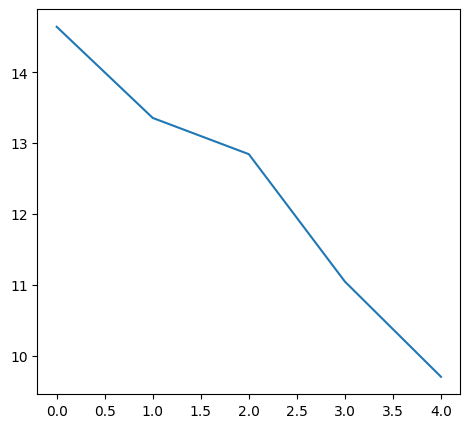

In [29]:
if history:
    df = pd.DataFrame(history)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # You might also have metrics like mAP if your dataset has a validation split
    # and the evaluation logic is enabled in the rfdetr package (it typically is).
    if 'val_map' in df.columns:
        plt.subplot(1, 2, 2)
        plt.plot(df['epoch'], df['val_map'], label='Validation mAP')
        plt.title('Validation mAP over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('mAP')
        plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No training history collected. Ensure callbacks were configured correctly.")

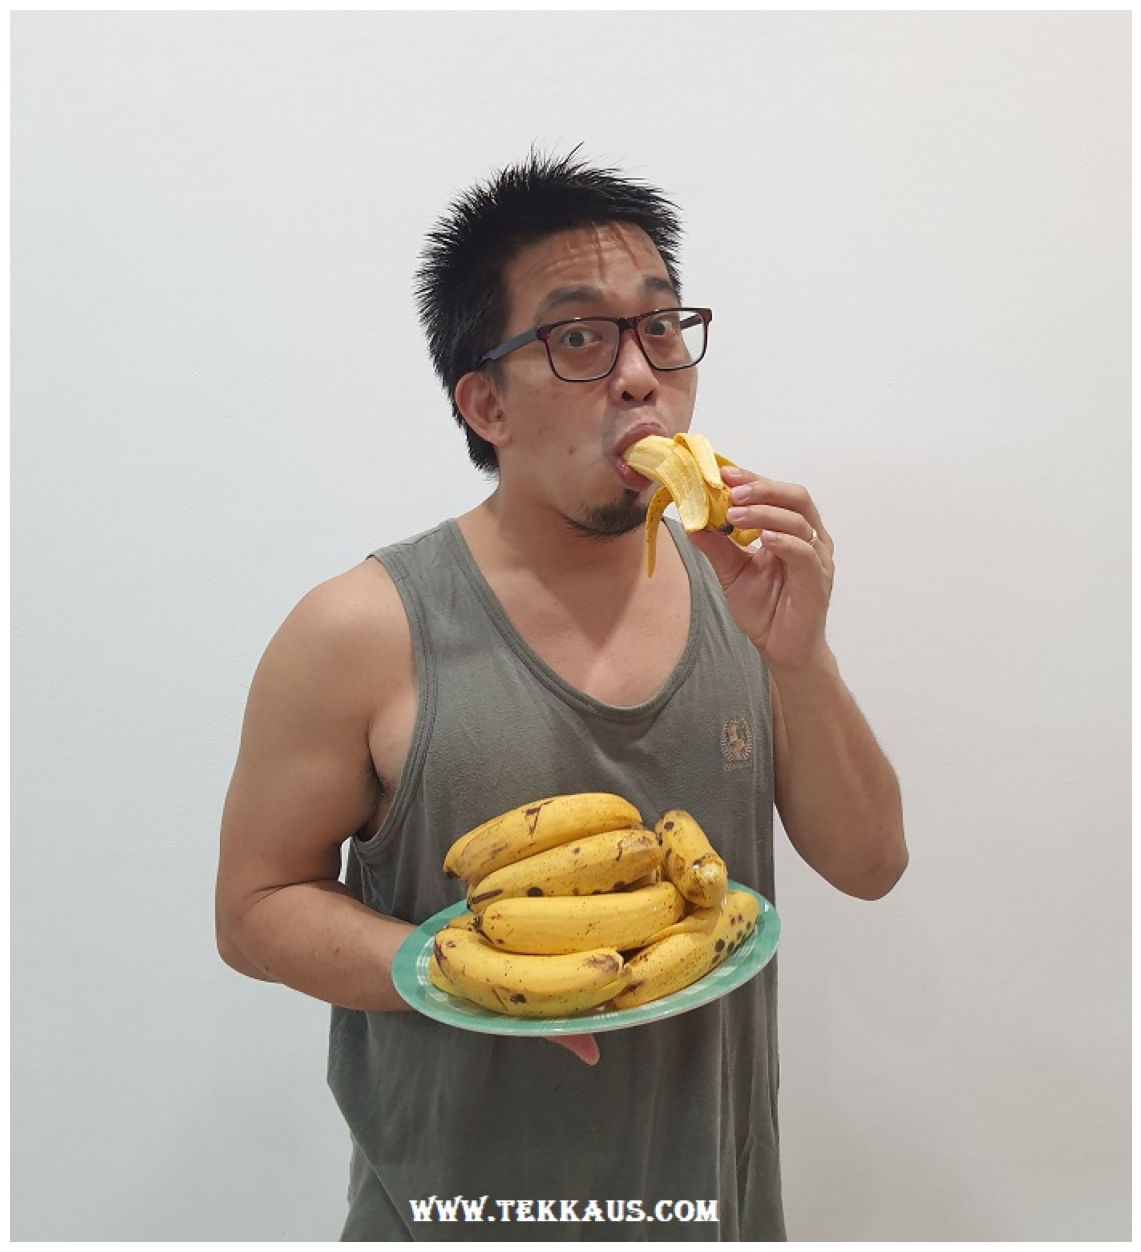

In [40]:
# Load the best model weights (usually saved in output_dir)
# The `train` method typically saves the best weights.
# You might need to specify the exact path or check the output_dir.
# For example, if it saves as `model_best.pth`:
#model.load_state_dict(torch.load(os.path.join(output_dir, "model_best.pth"), map_location=device))

# Or, if `model.train` handles saving and loading for subsequent `predict` calls,
# you might not need to explicitly load if you just ran train.

# --- Example of inference on a test image from your dataset ---
# Assuming your `dataset_dir` has a `test` folder with images
# Select a random image from the test set for inference
# For a full evaluation, you'd iterate over the whole test dataset and compute metrics.

# Example: Inference on a new image
new_image_path = "img2_rfdtr_test.jpg" # Replace with an actual test image
if os.path.exists(new_image_path):
    new_image = Image.open(new_image_path).convert("RGB")
    test_detections = model.predict(new_image, threshold=0.3)

    # Get class names for your custom dataset
    # This assumes you loaded them during dataset preparation
    # custom_class_names = list(category_names.values()) # From your COCO categories
    # Or, if you know them:
    custom_class_names = [
    'common-objects', 'aeroplane', 'backpack', 'banana', 'baseball bat',
    'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat',
    'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot',
    'cat', 'cell phone', 'chair', 'clock', 'cup', 'diningtable', 'dog',
    'donut', 'elephant', 'fork', 'frisbee', 'giraffe', 'handbag', 'horse',
    'hot dog', 'kite', 'knife', 'laptop', 'microwave', 'motorbike', 'mouse',
    'orange', 'oven', 'person', 'pizza', 'pottedplant', 'refrigerator',
    'remote', 'sandwich', 'scissors', 'sink', 'skateboard', 'skis',
    'snowboard', 'sofa', 'spoon', 'sports ball', 'stop sign', 'suitcase',
    'teddy bear', 'tennis racket', 'tie', 'toilet', 'toothbrush',
    'traffic light', 'train', 'truck', 'tvmonitor', 'umbrella', 'vase',
    'wine glass', 'zebra'
]

    test_labels = [
        f"{custom_class_names[class_id]} {confidence:.2f}"
        for class_id, confidence in zip(test_detections.class_id, test_detections.confidence)
    ]

    annotated_test_image = box_annotator.annotate(scene=new_image.copy(), detections=test_detections)
    annotated_test_image = label_annotator.annotate(scene=annotated_test_image, detections=test_detections, labels=test_labels)

    sv.plot_image(annotated_test_image, (16, 16))
    plt.show()
else:
    print(f"Test image not found at {new_image_path}")